# Goal

Reimplement XGBSE using apply function from RandomForest, followed by a LogisticRegression, or by Nearest Neighbors and Kaplan Meier.

In [123]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

from joblib import Parallel, delayed

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from xgbse.converters import convert_to_structured
from xgbse.metrics import concordance_index, approx_brier_score
from xgbse import XGBSEKaplanTree, XGBSEBootstrapEstimator, XGBSEDebiasedBCE
from xgbse._debiased_bce import _build_multi_task_targets
from xgbse._base import DummyLogisticRegression

from sksurv.metrics import concordance_index_censored, concordance_index_ipcw, cumulative_dynamic_auc, integrated_brier_score
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.functions import StepFunction

from pycox.datasets import metabric

In [4]:
plt.style.use('bmh')
set_matplotlib_formats('retina')

/var/folders/5w/hyfqlrq101nd83437kh5nlm00000gn/T/ipykernel_87426/2290035409.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


We begin by reproducing the exemple from [xgbse doc](https://loft-br.github.io/xgboost-survival-embeddings/basic-usage.html) using the Metabric dataset.

## 1. Quick exploration

In [5]:
# getting data
df = metabric.read_df()
df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
2,5.920251,6.776564,12.431715,5.873857,0.0,1.0,0.0,1.0,48.439999,140.233337,0
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
...,...,...,...,...,...,...,...,...,...,...,...
1899,5.946987,5.370492,12.345780,5.741395,1.0,1.0,0.0,1.0,76.839996,87.233330,1
1900,5.339228,5.408853,12.176101,5.693043,1.0,1.0,0.0,1.0,63.090000,157.533340,0
1901,5.901610,5.272237,14.200950,6.139390,0.0,0.0,0.0,1.0,57.770000,37.866665,1
1902,6.818109,5.372744,11.652624,6.077852,1.0,0.0,0.0,1.0,58.889999,198.433334,0


In [6]:
df.duration.describe()

count    1904.000000
mean      125.025124
std        76.334198
min         0.000000
25%        60.824999
50%       114.900002
75%       184.474995
max       355.200012
Name: duration, dtype: float64

Some duration are 0, meaning some patients were censored or got breast cancer at the beginning of the study.

In [7]:
df.event.value_counts() / df.shape[0]

1    0.579307
0    0.420693
Name: event, dtype: float64

42% of the patients were censored, the amount of censoring is pretty high, so metrics like the c-index might be biased upward.

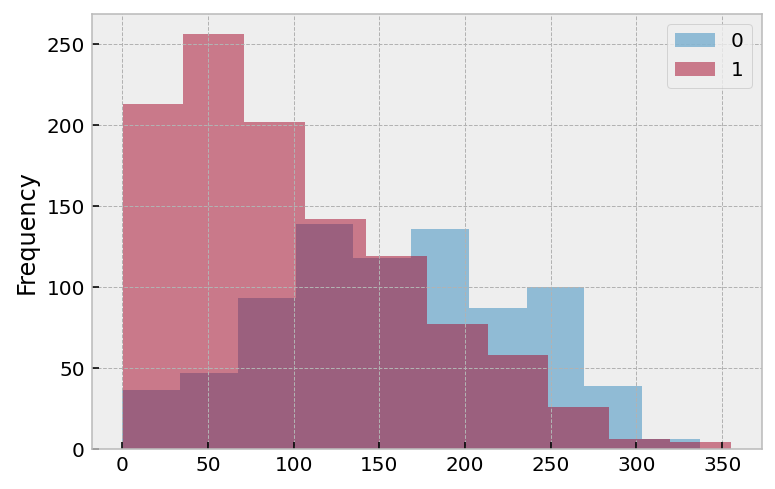

In [8]:
df.groupby("event")["duration"].plot.hist(alpha=0.5)
plt.legend();

Duration distribution between censoring (0) and event (1) are significantly different.

## Baselines

Preparing the data

In [482]:
gbsg_X, gbsg_y = load_gbsg2()
gbsg_X = encode_categorical(gbsg_X)
gbsg_X

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tgrade=II,tgrade=III,tsize
0,70.0,66.0,0.0,1.0,3.0,48.0,1.0,0.0,21.0
1,56.0,77.0,1.0,1.0,7.0,61.0,1.0,0.0,12.0
2,58.0,271.0,1.0,1.0,9.0,52.0,1.0,0.0,35.0
3,59.0,29.0,1.0,1.0,4.0,60.0,1.0,0.0,17.0
4,73.0,65.0,0.0,1.0,1.0,26.0,1.0,0.0,35.0
...,...,...,...,...,...,...,...,...,...
681,49.0,84.0,0.0,0.0,3.0,1.0,0.0,1.0,30.0
682,53.0,0.0,1.0,1.0,17.0,0.0,0.0,1.0,25.0
683,51.0,0.0,0.0,0.0,5.0,43.0,0.0,1.0,25.0
684,52.0,34.0,0.0,1.0,3.0,15.0,1.0,0.0,23.0


In [392]:
gbsg_X_train, gbsg_X_test, gbsg_y_train, gbsg_y_test = train_test_split(
    gbsg_X, gbsg_y, stratify=gbsg_y["cens"], random_state=1
)

# TODO: are those bounds too conservative?
lower, upper = np.percentile(gbsg_y["time"], [10, 90])
#gbsg_times = np.arange(lower, upper + 1)
gbsg_times = np.linspace(lower, upper, 1000)

### Simple Kaplan-Meier

In [541]:
km_func = StepFunction(
    *kaplan_meier_estimator(gbsg_y_test["cens"], gbsg_y_test["time"])
)
km_surv_prob = np.tile(km_func(gbsg_times), (gbsg_y_test.shape[0], 1))
km_surv_prob.shape

(172, 1000)

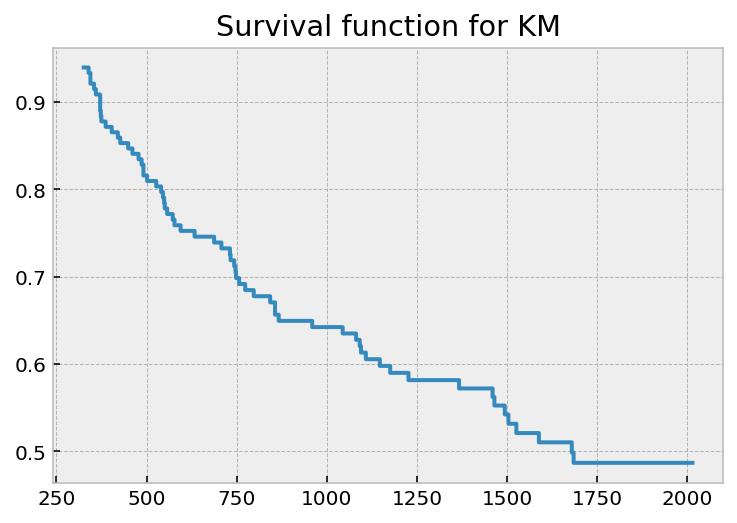

In [542]:
plt.step(gbsg_times, km_func(gbsg_times), where="post");
plt.title("Survival function for KM");

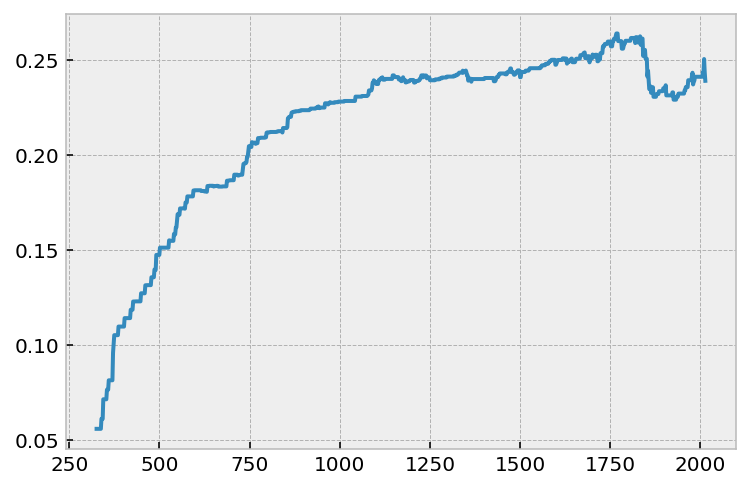

In [148]:
plt.plot(times, brier_scores);

In [545]:
integrated_brier_score(gbsg_y_train, gbsg_y_test, km_surv_prob, gbsg_times)

0.21589726942270474

In [546]:
_, auc_mean = cumulative_dynamic_auc(gbsg_y_train, gbsg_y_test, km_surv_prob, gbsg_times)
auc_mean

0.5

### Multiple Logistic Regression for cumulative hazard estimation

In [250]:
from sksurv.functions import StepFunction
from sksurv.tree.tree import _array_to_step_function

class MultiLR:
    
    def __init__(self, lr_params=None, n_jobs=1): 
        self.lr_params = lr_params or {}
        self.n_jobs = n_jobs

    def fit(self, X_train, y_train, time_bins=None):
        if time_bins is None:
            raise ValueError("'time_bins' is required")
        self.time_bins = time_bins
        e_name, t_name = y_train.dtype.names
        targets_train, _ = _build_multi_task_targets(
            E=y_train[e_name],
            T=y_train[t_name],
            time_bins=time_bins,
        )
        with Parallel(n_jobs=self.n_jobs) as parallel:
            estimators = parallel(
                delayed(self._fit_one_lr)(X_train, targets_train[:, i])
                for i in range(targets_train.shape[1])
            )
        self.estimators = estimators
        return self

    def _fit_one_lr(self, X_train, target):
        mask = target != -1

        if len(target[mask]) == 0:
            # If there's no observation in a time bucket we raise an error
            raise ValueError("Error: No observations in a time bucket")
        elif len(np.unique(target[mask])) == 1:
            # If there's only one class in a time bucket
            # we create a dummy classifier that predicts that class and send a warning
            classifier = DummyLogisticRegression()
        else:
            classifier = LogisticRegression(**self.lr_params)
        classifier.fit(X_train[mask, :], target[mask])
        return classifier
    
    def predict_survival_function(self, X_test, return_array=False):
        self.check_fitted()
        with Parallel(n_jobs=self.n_jobs) as parallel:
            y_preds = parallel(
                delayed(self._predict_one_lr)(X_test, estimator)
                for estimator in self.estimators
            )
        y_preds = np.asarray(y_preds)
        survival_probs = np.cumprod(1 - y_preds, axis=0).T
        if return_array:
            return survival_probs
        return _array_to_step_function(self.time_bins, survival_probs)
    
    def _predict_one_lr(self, X_test, estimator):
        y_pred = estimator.predict_proba(X_test)
        # return probability of "positive" event
        return y_pred[:, 1]
    
    def predict_cumulative_hazard_function(self, X_test, return_array=False):
        survival_probs = self.predict_survival_function(X_test, return_array=True)
        cumulative_hazards = -np.log(survival_probs)
        if return_array:
            return cumulative_hazards
        return _array_to_step_function(self.time_bins, cumulative_hazards)

    def predict(self, X_test):
        cumulative_hazards = self.predict_cumulative_hazard_function(X_test, return_array=True)
        return cumulative_hazards.sum(axis=1)
        
    def check_fitted(self):
        if not getattr(self, "estimators"):
            raise ValueError("MultiLR must be fitted first")

In [574]:
from sklearn.preprocessing import StandardScaler

lr_params = {"max_iter": 1000, "C": .1}
mlr = make_pipeline(StandardScaler(), MultiLR(lr_params=lr_params))
mlr.fit(gbsg_X_train, gbsg_y_train, multilr__time_bins=gbsg_times)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('multilr', <__main__.MultiLR object at 0x160990940>)])

In [548]:
survival_probs = mlr.predict_survival_function(gbsg_X_test, return_array=True)
print(survival_probs.shape)
print(survival_probs)

(172, 1000)
[[0.94946077 0.94946077 0.94946077 ... 0.47716436 0.47716436 0.47716436]
 [0.93025167 0.93025167 0.93025167 ... 0.43058703 0.43058703 0.43058703]
 [0.97325482 0.97325482 0.97325482 ... 0.4745269  0.4745269  0.4745269 ]
 ...
 [0.86670786 0.86670786 0.86670786 ... 0.42291227 0.42291227 0.42291227]
 [0.96563905 0.96563905 0.96563905 ... 0.50148318 0.50148318 0.50148318]
 [0.97408882 0.97408882 0.97408882 ... 0.4521331  0.4521331  0.4521331 ]]


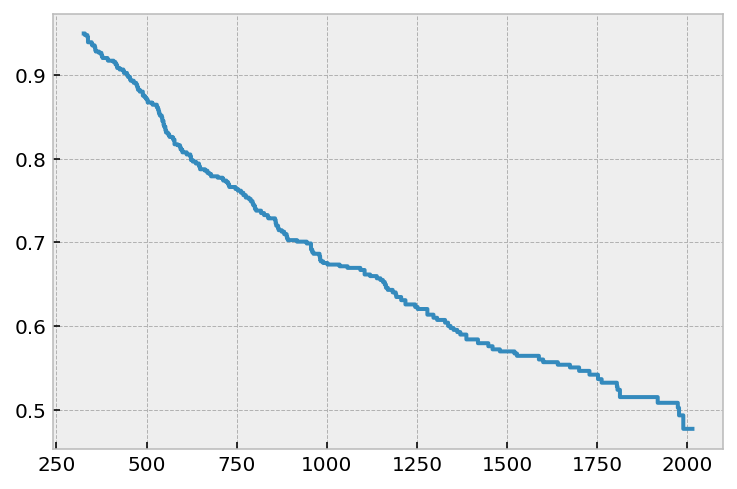

In [549]:
plt.step(gbsg_times, survival_probs[0]);

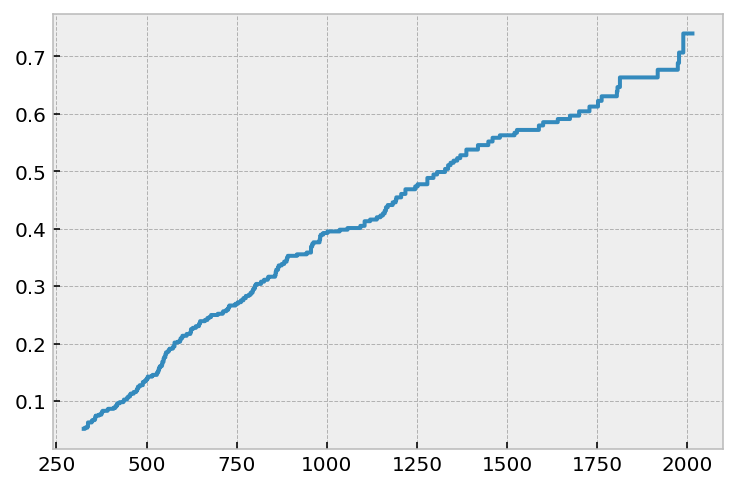

In [550]:
cumulative_hazards = mlr.predict_cumulative_hazard_function(gbsg_X_test, return_array=True)
plt.step(gbsg_times, cumulative_hazards[0]);

In [551]:
mlr.predict(gbsg_X_test)[0]

421.7232739936764

In [553]:
integrated_brier_score(gbsg_y_train, gbsg_y_test, survival_probs, gbsg_times)

0.2050624755458796

In [554]:
cumulative_dynamic_auc(gbsg_y, gbsg_y_test, cumulative_hazards, gbsg_times)[1]

0.7221478790167487

Let's play a little game...

"`estimate`" of `cumulative_dynamic_auc`:

    Estimated risk of experiencing an event of test data.
    If `estimate` is a 1-d array, the same risk score across all time
    points is used. If `estimate` is a 2-d array, the risk scores in the
    j-th column are used to evaluate the j-th time point.
    

"`estimate`" of `integrated_brier_score`:

    Estimated risk of experiencing an event for test data at `times`.
    The i-th column must contain the estimated probability of
    remaining event-free up to the i-th time point   

### MultiGBT

In [572]:
from sklearn.ensemble import HistGradientBoostingClassifier

class MultiHGBT:
    
    def __init__(self, hgbt_params=None, n_jobs=1): 
        self.hgbt_params = hgbt_params or {}
        self.n_jobs = n_jobs

    def fit(self, X_train, y_train, time_bins=None):
        if time_bins is None:
            raise ValueError("'time_bins' is required")
        self.time_bins = time_bins
        e_name, t_name = y_train.dtype.names
        targets_train, _ = _build_multi_task_targets(
            E=y_train[e_name],
            T=y_train[t_name],
            time_bins=time_bins,
        )
        with Parallel(n_jobs=self.n_jobs) as parallel:
            estimators = parallel(
                delayed(self._fit_one_lr)(X_train, targets_train[:, i])
                for i in range(targets_train.shape[1])
            )
        self.estimators = estimators
        return self

    def _fit_one_lr(self, X_train, target):
        mask = target != -1

        if len(target[mask]) == 0:
            # If there's no observation in a time bucket we raise an error
            raise ValueError("Error: No observations in a time bucket")
        elif len(np.unique(target[mask])) == 1:
            # If there's only one class in a time bucket
            # we create a dummy classifier that predicts that class and send a warning
            classifier = DummyLogisticRegression()
        else:
            classifier = HistGradientBoostingClassifier(**self.hgbt_params)
        classifier.fit(X_train[mask, :], target[mask])
        return classifier
    
    def predict_survival_function(self, X_test, return_array=False):
        self.check_fitted()
        with Parallel(n_jobs=self.n_jobs) as parallel:
            y_preds = parallel(
                delayed(self._predict_one_lr)(X_test, estimator)
                for estimator in self.estimators
            )
        y_preds = np.asarray(y_preds)
        survival_probs = np.cumprod(1 - y_preds, axis=0).T
        if return_array:
            return survival_probs
        return _array_to_step_function(self.time_bins, survival_probs)
    
    def _predict_one_lr(self, X_test, estimator):
        y_pred = estimator.predict_proba(X_test)
        # return probability of "positive" event
        return y_pred[:, 1]
    
    def predict_cumulative_hazard_function(self, X_test, return_array=False):
        survival_probs = self.predict_survival_function(X_test, return_array=True)
        cumulative_hazards = -np.log(survival_probs)
        if return_array:
            return cumulative_hazards
        return _array_to_step_function(self.time_bins, cumulative_hazards)

    def predict(self, X_test):
        cumulative_hazards = self.predict_cumulative_hazard_function(X_test, return_array=True)
        return cumulative_hazards.sum(axis=1)
        
    def check_fitted(self):
        if not getattr(self, "estimators"):
            raise ValueError("MultiLR must be fitted first")

In [658]:
hgbt_params = {
    "learning_rate": .2,
    "min_samples_leaf": 100,
    "loss": "log_loss",
    "max_iter": 20,
    "l2_regularization": .5,
}
multi_hgbt = make_pipeline(StandardScaler(), MultiHGBT(hgbt_params=hgbt_params))
multi_hgbt.fit(gbsg_X_train, gbsg_y_train, multihgbt__time_bins=gbsg_times)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('multihgbt', <__main__.MultiHGBT object at 0x1653b3f10>)])

In [659]:
survival_probs = multi_hgbt.predict_survival_function(gbsg_X_test, return_array=True)
print(survival_probs.shape)
print(survival_probs)

(172, 1000)
[[0.84776137 0.84776137 0.84776137 ... 0.34714689 0.34714689 0.34714689]
 [0.8246542  0.8246542  0.8246542  ... 0.308714   0.308714   0.308714  ]
 [0.99299383 0.99299383 0.99299383 ... 0.45761967 0.45761967 0.45761967]
 ...
 [0.76094997 0.76094997 0.76094997 ... 0.31533193 0.31533193 0.31533193]
 [0.9619501  0.9619501  0.9619501  ... 0.47691453 0.47691453 0.47691453]
 [0.98723453 0.98723453 0.98723453 ... 0.51464671 0.51464671 0.51464671]]


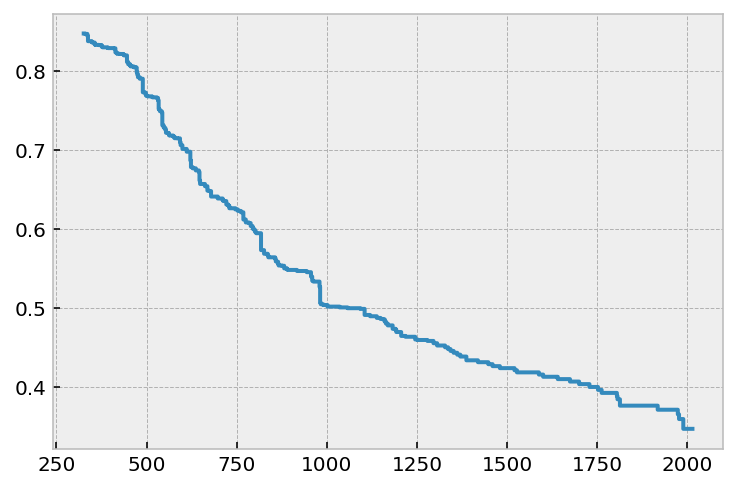

In [660]:
plt.step(gbsg_times, survival_probs[0]);

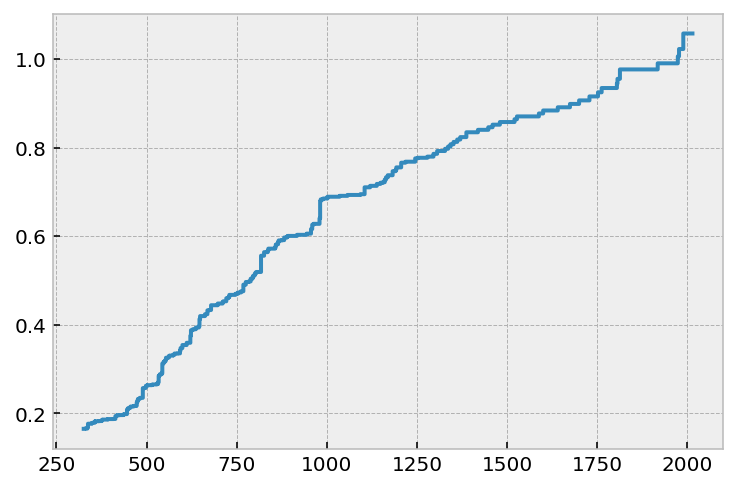

In [661]:
cumulative_hazards = multi_hgbt.predict_cumulative_hazard_function(gbsg_X_test, return_array=True)
plt.step(gbsg_times, cumulative_hazards[0]);

In [662]:
multi_hgbt.predict(gbsg_X_test)[0]

673.0171917397447

In [663]:
integrated_brier_score(gbsg_y_train, gbsg_y_test, survival_probs, gbsg_times)

0.19549983931015422

In [664]:
cumulative_dynamic_auc(gbsg_y_train, gbsg_y_test, cumulative_hazards, gbsg_times)[1]

0.7027570891753387

### SurvivalForestDebiasedBCE

In [555]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.preprocessing import OneHotEncoder

class SurvivalForestDebiasedBCE:
    
    def __init__(self, sf_params=None, lr_params=None, n_jobs=1): 
        self.sf_params = sf_params or {}
        self.lr_params = lr_params or {}
        self.n_jobs = n_jobs

    def fit(self, X_train, y_train, time_bins=None):
        if time_bins is None:
            raise ValueError("'time_bins' is required")    
        self.time_bins_ = time_bins
        
        self.sf_ = RandomSurvivalForest(**self.sf_params).fit(X_train, y_train)
        X_trans = self.sf_.apply(X_train)
        #import ipdb; ipdb.set_trace()
        self.ohe_ = OneHotEncoder()
        X_trans = self.ohe_.fit_transform(X_trans)
        self.mlr_ = MultiLR(lr_params=self.lr_params, n_jobs=self.n_jobs)
        self.mlr_.fit(X_trans, y_train, time_bins=time_bins)
        return self
    
    def predict_survival_function(self, X_test, return_array=False):
        self.check_fitted()
        
        X_trans = self.ohe_.transform(self.sf_.apply(X_test))
        return self.mlr_.predict_survival_function(X_trans, return_array=return_array)
    
    def predict_cumulative_hazard_function(self, X_test, return_array=False):
        self.check_fitted()
        
        X_trans = self.ohe_.transform(self.sf_.apply(X_test))
        return self.mlr_.predict_cumulative_hazard_function(X_trans, return_array=return_array)
        
    def predict(self, X_test):
        cumulative_hazards = self.predict_cumulative_hazard_function(X_test, return_array=True)
        return cumulative_hazards.sum(axis=1)
        
    def check_fitted(self):
        if not getattr(self, "sf_"):
            raise ValueError("MultiLR must be fitted first")

In [556]:
lr_params = {} #{"max_iter": 1000, "C": .1}
sf_params = {"min_samples_leaf": 50, "n_estimators": 3}
sfdbce = make_pipeline(
    StandardScaler(),
    SurvivalForestDebiasedBCE(sf_params=sf_params, lr_params=lr_params)
)
sfdbce.fit(gbsg_X_train, gbsg_y_train, survivalforestdebiasedbce__time_bins=gbsg_times)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('survivalforestdebiasedbce',
                 <__main__.SurvivalForestDebiasedBCE object at 0x1602dd000>)])

In [557]:
survival_probs = sfdbce.predict_survival_function(gbsg_X_test, return_array=True)
print(survival_probs.shape)
print(survival_probs)

(172, 1000)
[[0.87211435 0.87211435 0.87211435 ... 0.40213663 0.40213663 0.40213663]
 [0.85301465 0.85301465 0.85301465 ... 0.29465982 0.29465982 0.29465982]
 [0.99295042 0.99295042 0.99295042 ... 0.52396932 0.52396932 0.52396932]
 ...
 [0.7405628  0.7405628  0.7405628  ... 0.33474831 0.33474831 0.33474831]
 [0.94779928 0.94779928 0.94779928 ... 0.43519387 0.43519387 0.43519387]
 [0.96343782 0.96343782 0.96343782 ... 0.49332155 0.49332155 0.49332155]]


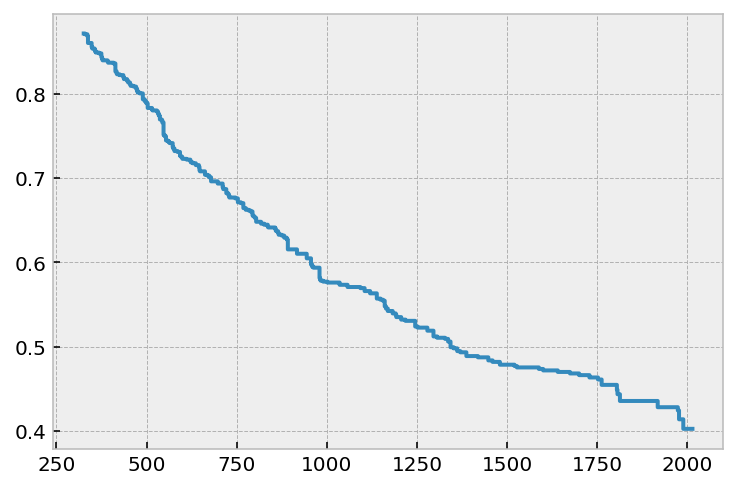

In [558]:
plt.step(gbsg_times, survival_probs[0]);

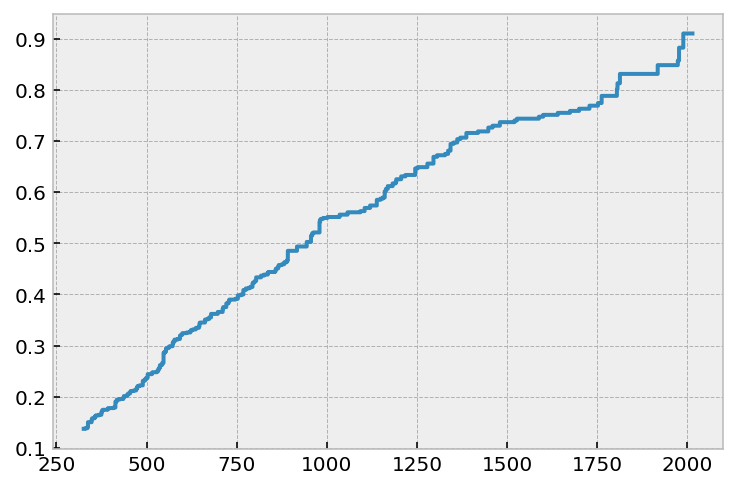

In [559]:
cumulative_hazards = sfdbce.predict_cumulative_hazard_function(gbsg_X_test, return_array=True)
plt.step(gbsg_times, cumulative_hazards[0]);

In [560]:
from collections import Counter
from pprint import pprint

model_ = sfdbce.steps[1][1]
pprint(Counter([type(est) for est in model_.mlr_.estimators]))

Counter({<class 'xgbse._base.DummyLogisticRegression'>: 835,
         <class 'sklearn.linear_model._logistic.LogisticRegression'>: 165})


In [561]:
sfdbce.predict(gbsg_X_test)[0]

567.8912246876183

In [562]:
integrated_brier_score(gbsg_y_train, gbsg_y_test, survival_probs, gbsg_times)

0.19227607665253124

In [563]:
cumulative_dynamic_auc(gbsg_y_train, gbsg_y_test, cumulative_hazards, gbsg_times)[1]

0.7404116370878819

## XGBSE KaplanTree

### 2.1 XGBSE model

In [17]:
# splitting to X, T, E format
#X = df.drop(['duration', 'event'], axis=1)
#T = df['duration']
#E = df['event']
#y = convert_to_structured(T, E)

# splitting between train, and validation
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state = 0)
#TIME_BINS = np.arange(15, 315, 15)

In [314]:
# xgboost parameters to fit our model
params_tree = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist',
    'max_depth': 10,
    'booster':'dart',
    'subsample': 1.0,
    'min_child_weight': 50,
    'colsample_bynode': 1.0
}

In [316]:
xgbse_knn = XGBSEKaplanTree(params_tree)
xgbse_knn.fit(gbsg_X_train, gbsg_y_train, time_bins=gbsg_times)

XGBSEKaplanTree(xgb_params={'booster': 'dart', 'colsample_bynode': 1.0,
                            'eval_metric': 'cox-nloglik', 'max_depth': 10,
                            'min_child_weight': 50, 'objective': 'survival:cox',
                            'subsample': 1.0, 'tree_method': 'hist'})

In [319]:
xgbse_survival_probs = xgbse_knn.predict(gbsg_X_test, return_ci=False, return_interval_probs=False)
xgbse_survival_probs

,325.500000,327.190190,328.880380,330.570571,332.260761,333.950951,335.641141,337.331331,339.021522,340.711712,...,1998.788288,2000.478478,2002.168669,2003.858859,2005.549049,2007.239239,2008.929429,2010.619620,2012.309810,2014.000000
0,0.858165,0.858165,0.858165,0.858165,0.858165,0.858165,0.858165,0.852699,0.841767,0.841767,...,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462
1,0.858165,0.858165,0.858165,0.858165,0.858165,0.858165,0.858165,0.852699,0.841767,0.841767,...,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462
2,0.981899,0.981899,0.981899,0.972808,0.972808,0.972808,0.972808,0.972808,0.972808,0.972808,...,0.483327,0.483327,0.483327,0.483327,0.483327,0.483327,0.483327,0.483327,0.483327,0.483327
3,0.981899,0.981899,0.981899,0.972808,0.972808,0.972808,0.972808,0.972808,0.972808,0.972808,...,0.483327,0.483327,0.483327,0.483327,0.483327,0.483327,0.483327,0.483327,0.483327,0.483327
4,0.858165,0.858165,0.858165,0.858165,0.858165,0.858165,0.858165,0.852699,0.841767,0.841767,...,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,0.858165,0.858165,0.858165,0.858165,0.858165,0.858165,0.858165,0.852699,0.841767,0.841767,...,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462
168,0.980194,0.980194,0.980194,0.980194,0.980194,0.980194,0.980194,0.980194,0.980194,0.980194,...,0.723550,0.723550,0.723550,0.723550,0.723550,0.723550,0.723550,0.723550,0.723550,0.723550
169,0.858165,0.858165,0.858165,0.858165,0.858165,0.858165,0.858165,0.852699,0.841767,0.841767,...,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462,0.275462
170,0.981899,0.981899,0.981899,0.972808,0.972808,0.972808,0.972808,0.972808,0.972808,0.972808,...,0.483327,0.483327,0.483327,0.483327,0.483327,0.483327,0.483327,0.483327,0.483327,0.483327


In [327]:
integrated_brier_score(gbsg_y_train, gbsg_y_test, xgbse_survival_probs, gbsg_times)

0.19610297965315965

In [330]:
xgbse_cumulative_hazard = -np.log(xgbse_survival_probs)
cumulative_dynamic_auc(gbsg_y_train, gbsg_y_test, xgbse_cumulative_hazard, gbsg_times)[1]

0.6723611631821471

### 2.2. Scikit RandomForest + NearestNeighbors + Kaplan Meier

We fit a non-survival aware RF Classifier on the event target by selecting values before a user-determined horizon. After fitting, we simply get the index of the leaves using the `apply` method.

Note: we initially intended to use scikit-survival RF to use `apply`, but the `apply` method is not implemented in `SurvivalTree`. See the issue we filed: https://github.com/sebp/scikit-survival/issues/290#issuecomment-1220502502

In [ ]:
class RandomForestKNN():
    
    def __init__(self, horizon):
        self.horizon = horizon
    
    def fit(self, X_train, y_train):
        horizon_mask = gbsg_y_train["time"] < self.horizon
        X_train_masked = gbsg_X_train.reset_index(drop=True)[horizon_mask]
        self.y_train_masked_ = gbsg_y_train[horizon_mask]
        
        self.rf_ = RandomForestClassifier().fit(X_train_masked, self.y_train_masked_["cens"])
        self.X_trans = self.rf_.apply(X_train_masked)
        self.knn_ = NearestNeighbors(n_neighbors=30).fit(X_trans)
        return self
    
    def predict_survival_function(self, X_test, return_array=False):
        X_trans = self.rf_.apply(X_test)
        knn_idxs = self.knn_.kneighbors(X_trans, return_distance=False)
        
        
        
        survival_probs = np.cumprod(1 - y_preds, axis=0).T
        if return_array:
            return survival_probs
        return _array_to_step_function(self.time_bins, survival_probs)
        

In [338]:
horizon = 2000
rf_knn = RandomForestKNN(horizon)

((458, 9), (458,))

In [344]:
rf = RandomForestClassifier()
rf.fit(X_train_masked, y_train_masked["cens"])
X_train_embedded = rf.apply(gbsg_X_train)
X_test_embedded = rf.apply(gbsg_X_test)

Now fit `NearestNeigbors` to build an search index and search for the closest neighbors for each sample of the test dataset. We set the `n_neighbors` hyper-parameter to 30 like in XGBSE implementation.

In [345]:
knn = NearestNeighbors(n_neighbors=30)
knn.fit(X_train_embedded)
X_test_neighbors_idx = knn.kneighbors(X_test_embedded, return_distance=False)
X_test_neighbors_idx

array([[321, 470,  37, ..., 245,  42, 146],
       [ 76, 452, 219, ..., 185, 234, 366],
       [ 52, 246,  51, ...,  49,  14, 145],
       ...,
       [345, 275, 313, ..., 375, 501, 366],
       [492, 333,  36, ..., 167,  28, 248],
       [262,  68,  27, ..., 442, 505, 249]])

Finally, we fit the closest neighbors of each test sample in a Kaplan Meier estimator before computing scoring metrics.

Due to implementation, Kaplan Meier returns an array of time and probability at each input event. However, we need an prediction array with contiguous times to compute our scoring metrics. Therefore, we need to propagate probabilities values between each time event.

In [346]:
def (T, X_test_neighbors_idx, y_train, estimator):
    """
    Compute Kaplan-Meier survival estimate or Nelson-Aalen cumulative risk.
    """
    preds = []
    max_duration = T.max()
    for row in X_test_neighbors_idx:
        y_train_row = y_train_df.iloc[row]
        time, prob_survival = estimator(
            y_train_row["event"],
            y_train_row["duration"],
        )
        _, prob_survival = oversample_km_preds(time, prob_survival, max_duration)
        preds.append(prob_survival)
    df_preds = pd.DataFrame(np.vstack(preds))
    return df_preds


def oversample_km_preds(time, prob_survival, horizon):
    """
    Backfill probabilities between time values to create a time grid,
    from 0 to horizon.

    Exemple
    -------
    time = [2, 5]
    prob_survival = [0.96, 0.88]
    horizon = 5
    over_sample_km_preds(time, prob_survival, horizon)
    >>> (0, 1, 2, 3, 4, 5), (0.96, 0.96, 0.96, 0.88, 0.88) # time, prob_survival
    """
    time = time.round().astype(int)
    df_preds = pd.DataFrame({"time": time, "prob_survival": prob_survival})
    df_preds.drop_duplicates(subset=["time"], keep="last", inplace=True)
    df_time_index = pd.DataFrame({"time": np.arange(0, horizon+1)})
    df_time_index = df_time_index.merge(df_preds, on="time", how="left")
    df_time_index.fillna(method="bfill", inplace=True)
    
    return df_time_index.time.values, df_time_index.prob_survival.values

In [347]:
s_sk_knn_df = get_nonparametric_preds(T, X_test_neighbors_idx, y_train_df, kaplan_meier_estimator)
s_sk_knn_df.shape

NameError: name 'y_train_df' is not defined

In [15]:
H_sk_knn_df = get_nonparametric_preds(T, X_test_neighbors_idx, y_train_df, nelson_aalen_estimator)
H_sk_knn_df.shape

(635, 357)

Let's now compute the cumulative hazard.

In [16]:
H_sk_knn_df = H_sk_knn_df.replace(np.inf, np.nan).fillna(1)
H_sk_knn_df = np.clip(H_sk_knn_df, 0, 1)[TIME_BINS]
H_sk_knn_df

,15,30,45,60,75,90,105,120,135,150,165,180,195,210,225,240,255,270,285,300
0,0.067816,0.067816,0.067816,0.104853,0.193786,0.193786,0.193786,0.193786,0.193786,0.193786,0.265215,0.265215,0.356124,0.567235,0.567235,0.567235,0.733901,0.733901,1.000000,1.000000
1,0.103530,0.179029,0.179029,0.260696,0.306150,0.511956,0.570780,0.633280,0.931632,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,0.034483,0.034483,0.034483,0.149981,0.191648,0.239267,0.439862,0.516785,0.516785,0.659643,0.826309,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,0.067816,0.067816,0.140567,0.179029,0.179029,0.311793,0.414425,0.469980,0.684998,0.684998,0.875907,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,0.067816,0.103530,0.103530,0.260696,0.304174,0.397247,0.449879,0.508703,0.709298,0.709298,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,0.033333,0.067816,0.067816,0.103530,0.179029,0.397247,0.449879,0.841776,0.941776,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
631,0.033333,0.260696,0.447247,0.447247,0.555435,0.555435,0.555435,0.555435,0.555435,0.555435,0.555435,0.555435,0.555435,0.555435,0.555435,0.755435,0.755435,0.755435,0.755435,0.755435
632,0.033333,0.033333,0.103530,0.180567,0.180567,0.276022,0.443033,0.505533,0.779775,0.890886,0.890886,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
633,0.033333,0.033333,0.140567,0.304174,0.351793,0.507056,0.565880,0.565880,0.642803,0.642803,0.726136,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3.2 XGBSE DebiasedBCE

### 3.1 XGBSE implementation

In [17]:
%%time

xgbse_bce = XGBSEDebiasedBCE(PARAMS_TREE)
xgbse_bce.fit(X_train, y_train, time_bins=TIME_BINS)

CPU times: user 5min 50s, sys: 4.19 s, total: 5min 54s
Wall time: 47.8 s


XGBSEDebiasedBCE(lr_params={'C': 0.001, 'max_iter': 500},
                 xgb_params={'booster': 'dart', 'colsample_bynode': 1.0,
                             'eval_metric': 'cox-nloglik', 'max_depth': 10,
                             'min_child_weight': 50,
                             'objective': 'survival:cox', 'subsample': 1.0,
                             'tree_method': 'hist'})

In [18]:
# predicting
s_xgbse_bce_df = xgbse_bce.predict(X_test)
h_xgbse_bce_df = xgbse_bce.predict(X_test, return_interval_probs=True)
H_xgbse_bce_df = h_xgbse_bce_df.cumsum(axis=1)
H_xgbse_bce_df

,15,30,45,60,75,90,105,120,135,150,165,180,195,210,225,240,255,270,285,300
0,0.017223,0.052299,0.083211,0.106871,0.152577,0.238318,0.317088,0.347549,0.380576,0.417471,0.460218,0.512220,0.534167,0.589807,0.637638,0.708248,0.746184,0.795718,0.831556,0.869309
1,0.031720,0.112077,0.192020,0.322316,0.374596,0.481477,0.546469,0.681891,0.723668,0.736552,0.795362,0.825619,0.844343,0.868644,0.893754,0.913872,0.922739,0.943733,0.952729,0.964462
2,0.015960,0.048480,0.096287,0.123359,0.170241,0.268748,0.323282,0.398699,0.467598,0.521924,0.566976,0.598620,0.621133,0.658203,0.694415,0.753213,0.788524,0.837659,0.863835,0.898106
3,0.014262,0.044659,0.090553,0.154037,0.184219,0.248086,0.350293,0.392158,0.431692,0.470758,0.518373,0.578064,0.604273,0.642061,0.708371,0.768224,0.822484,0.859088,0.881957,0.909863
4,0.024486,0.057649,0.113088,0.182547,0.244797,0.352523,0.426117,0.462286,0.493231,0.529822,0.574097,0.602658,0.629695,0.694281,0.768707,0.802227,0.829042,0.872836,0.899091,0.925423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,0.018955,0.062778,0.107166,0.186307,0.238329,0.322147,0.348874,0.435094,0.473850,0.519428,0.578567,0.630699,0.668160,0.703188,0.778578,0.808210,0.843948,0.887745,0.908862,0.931785
631,0.027678,0.170239,0.259406,0.348844,0.382698,0.410621,0.428151,0.445934,0.463374,0.482069,0.504102,0.517197,0.535078,0.571375,0.600682,0.628425,0.668501,0.728292,0.765911,0.810794
632,0.016025,0.051342,0.092895,0.173198,0.204329,0.246622,0.350427,0.402536,0.479486,0.504220,0.557004,0.633475,0.655740,0.691035,0.753817,0.809961,0.854056,0.889243,0.908455,0.929598
633,0.023166,0.060539,0.146417,0.236472,0.282272,0.371569,0.458791,0.493827,0.526470,0.545241,0.592111,0.648267,0.680231,0.766693,0.823757,0.851436,0.871148,0.906304,0.926782,0.945502


### 3.2 Scikit RandomForest + Multiple Logistic Regression + Kaplan Meier

We keep the same embeddings, but use those to fit multiple logistic regression instead (one per time step)

In [19]:
from xgbse._debiased_bce import _build_multi_task_targets

E_train, T_train = zip(*y_train)
train_targets, _ = _build_multi_task_targets(E_train, T_train, TIME_BINS)
train_targets.shape

(1269, 20)

In [20]:
def fit_multi_lr(X, y, n_jobs=3):
    with Parallel(n_jobs=n_jobs) as parallel:
        lr_estimators = parallel(
        delayed(fit_one_lr)(X, y[:, jdx])
        for jdx in range(y.shape[1])
    )
    return lr_estimators


def fit_one_lr(X, y):
    lr = LogisticRegression()
    mask = y != -1
    lr.fit(X[mask, :], y[mask])
    return lr


def predict_multi_lr(lr_estimators, X, time_bins, n_jobs=3):
    with Parallel(n_jobs=n_jobs) as parallel:
        preds = parallel(
        delayed(lr.predict_proba)(X)
        for lr in lr_estimators
    )
    preds = np.array(preds)[:, :, 1].T
    preds = pd.DataFrame(preds, columns=time_bins)
    # hazards to survival (Kaplan Meier estimator)
    preds = (1 - preds).cumprod(axis=1)
    return preds

In [21]:
lr_estimators = fit_multi_lr(X_train_embedded, train_targets)
s_sk_bce_df = predict_multi_lr(lr_estimators, X_test_embedded, TIME_BINS)
s_sk_bce_df

/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/vincentmaladiere/mambaforge/envs/skurvival/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

,15,30,45,60,75,90,105,120,135,150,165,180,195,210,225,240,255,270,285,300
0,0.998790,0.506059,0.488603,0.480965,0.480534,0.475137,0.471106,0.453048,0.452818,0.452818,0.452818,4.528184e-01,4.528184e-01,4.514903e-01,4.514903e-01,4.514903e-01,4.514903e-01,8.614247e-03,2.077403e-03,2.077370e-03
1,0.996839,0.968612,0.930015,0.753815,0.752287,0.665986,0.574132,0.428056,0.418269,0.418269,0.390321,3.903212e-01,3.903212e-01,3.675115e-01,3.675115e-01,3.675115e-01,3.675115e-01,3.642233e-01,3.642036e-01,2.015463e-01
2,0.999892,0.866355,0.862270,0.855292,0.853116,0.850814,0.691045,0.680108,0.677907,0.677907,0.677907,6.779071e-01,6.779071e-01,6.779071e-01,6.779071e-01,6.779071e-01,6.779071e-01,6.716514e-01,6.604607e-01,6.601436e-01
3,1.000000,0.998764,0.943794,0.916189,0.915469,0.913439,0.802496,0.792311,0.767114,0.767114,0.766796,7.667958e-01,7.667958e-01,7.667953e-01,7.667953e-01,8.955048e-02,2.966208e-03,2.514438e-03,2.513476e-03,2.501641e-03
4,0.997494,0.996711,0.993945,0.927880,0.895146,0.794220,0.766804,0.764204,0.761260,0.717036,0.717034,7.170344e-01,7.170344e-01,7.170344e-01,7.170343e-01,7.170343e-01,7.170160e-01,4.929270e-03,4.929255e-03,4.895395e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,0.999751,0.956001,0.944482,0.928897,0.894747,0.836263,0.834603,0.722337,0.714870,0.000192,0.000192,1.923060e-04,1.919556e-04,1.919556e-04,1.278586e-04,1.278563e-04,1.278563e-04,1.261299e-04,1.259613e-04,1.081474e-05
631,0.957362,0.669023,0.591661,0.541653,0.528478,0.527974,0.527612,0.513357,0.513031,0.513031,0.002551,2.550675e-03,2.550675e-03,2.550675e-03,2.550675e-03,2.550675e-03,2.550668e-03,2.374181e-03,2.374181e-03,2.374180e-03
632,0.999883,0.993087,0.983907,0.912377,0.911700,0.897173,0.828818,0.739259,0.695047,0.695047,0.668199,1.359185e-10,1.359185e-10,1.359185e-10,1.359185e-10,2.876989e-11,1.270993e-17,1.972744e-19,1.945403e-19,1.945403e-19
633,0.995409,0.986910,0.877008,0.849356,0.824997,0.557989,0.488688,0.485178,0.475206,0.475156,0.472075,4.720748e-01,4.720748e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [22]:
from xgbse.converters import hazard_to_survival

h_sk_bce_df = hazard_to_survival(s_sk_bce_df)
H_sk_bce_df = h_sk_bce_df.cumsum(axis=1)

## 4. Results

In [31]:
pd.DataFrame(
    {
        "C-index (higher is better)": [
            concordance_index(y_test, s_xgbse_knn_df),
            concordance_index(y_test, s_sk_knn_df),
            concordance_index(y_test, s_xgbse_bce_df),
            concordance_index(y_test, s_sk_bce_df),
        ], 
        "Brier Score (lower is better)": [
            approx_brier_score(y_test, s_xgbse_knn_df),
            approx_brier_score(y_test, s_sk_knn_df),
            approx_brier_score(y_test, s_xgbse_bce_df),
            approx_brier_score(y_test, s_sk_bce_df),
        ],
    },
    index=["XGBSEKaplanTree", "Scikit KNN", "XGBSEDebiasedBCE", "Scikit BCE"]
)

,C-index (higher is better),Brier Score (lower is better)
XGBSEKaplanTree,0.635894,0.182841
Scikit KNN,0.635172,0.137415
XGBSEDebiasedBCE,0.664781,0.174173
Scikit BCE,0.562581,0.253598


Scikit KNN has very decent performances, wheareas Scikit BCE performs poorly. 
- The C-index of Scikit KNN is slighly below `XBSEDebiasedBCE` and matches `XBSEKaplanTree`.
- On the other hand, the Brier score is lower than both XGBSE models by a significant margin.

As our censoring is close to 50%, Brier score is a more reliable metrics than C-index, both for discrimination and calibration, hence the performance of Scikit KNN are encouraging.

In [25]:
def plot_dynamic_auc(auc_xgbse_knn, auc_sk_knn, auc_xgbse_bce, auc_sk_bce):
    plt.figure(figsize=(12, 4), dpi=120)
    plt.plot(TIME_BINS, auc_xgbse_knn, "o-", label="XGBSEKaplanTree (mean AUC = {:.3f})".format(auc_xgbse_knn.mean()))
    plt.plot(TIME_BINS, auc_sk_knn, "o-", label="Scikit KNN (mean AUC = {:.3f})".format(auc_sk_knn.mean()))
    plt.plot(TIME_BINS, auc_xgbse_bce, "o-", label="XGBSEDebiasedBCE (mean AUC = {:.3f})".format(auc_xgbse_bce.mean()))
    plt.plot(TIME_BINS, auc_sk_bce, "o-", label="Scikit BCE (mean AUC = {:.3f})".format(auc_sk_bce.mean()))
    plt.title("Dynamic AUC")
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.legend(loc="lower center")
    plt.grid(True)

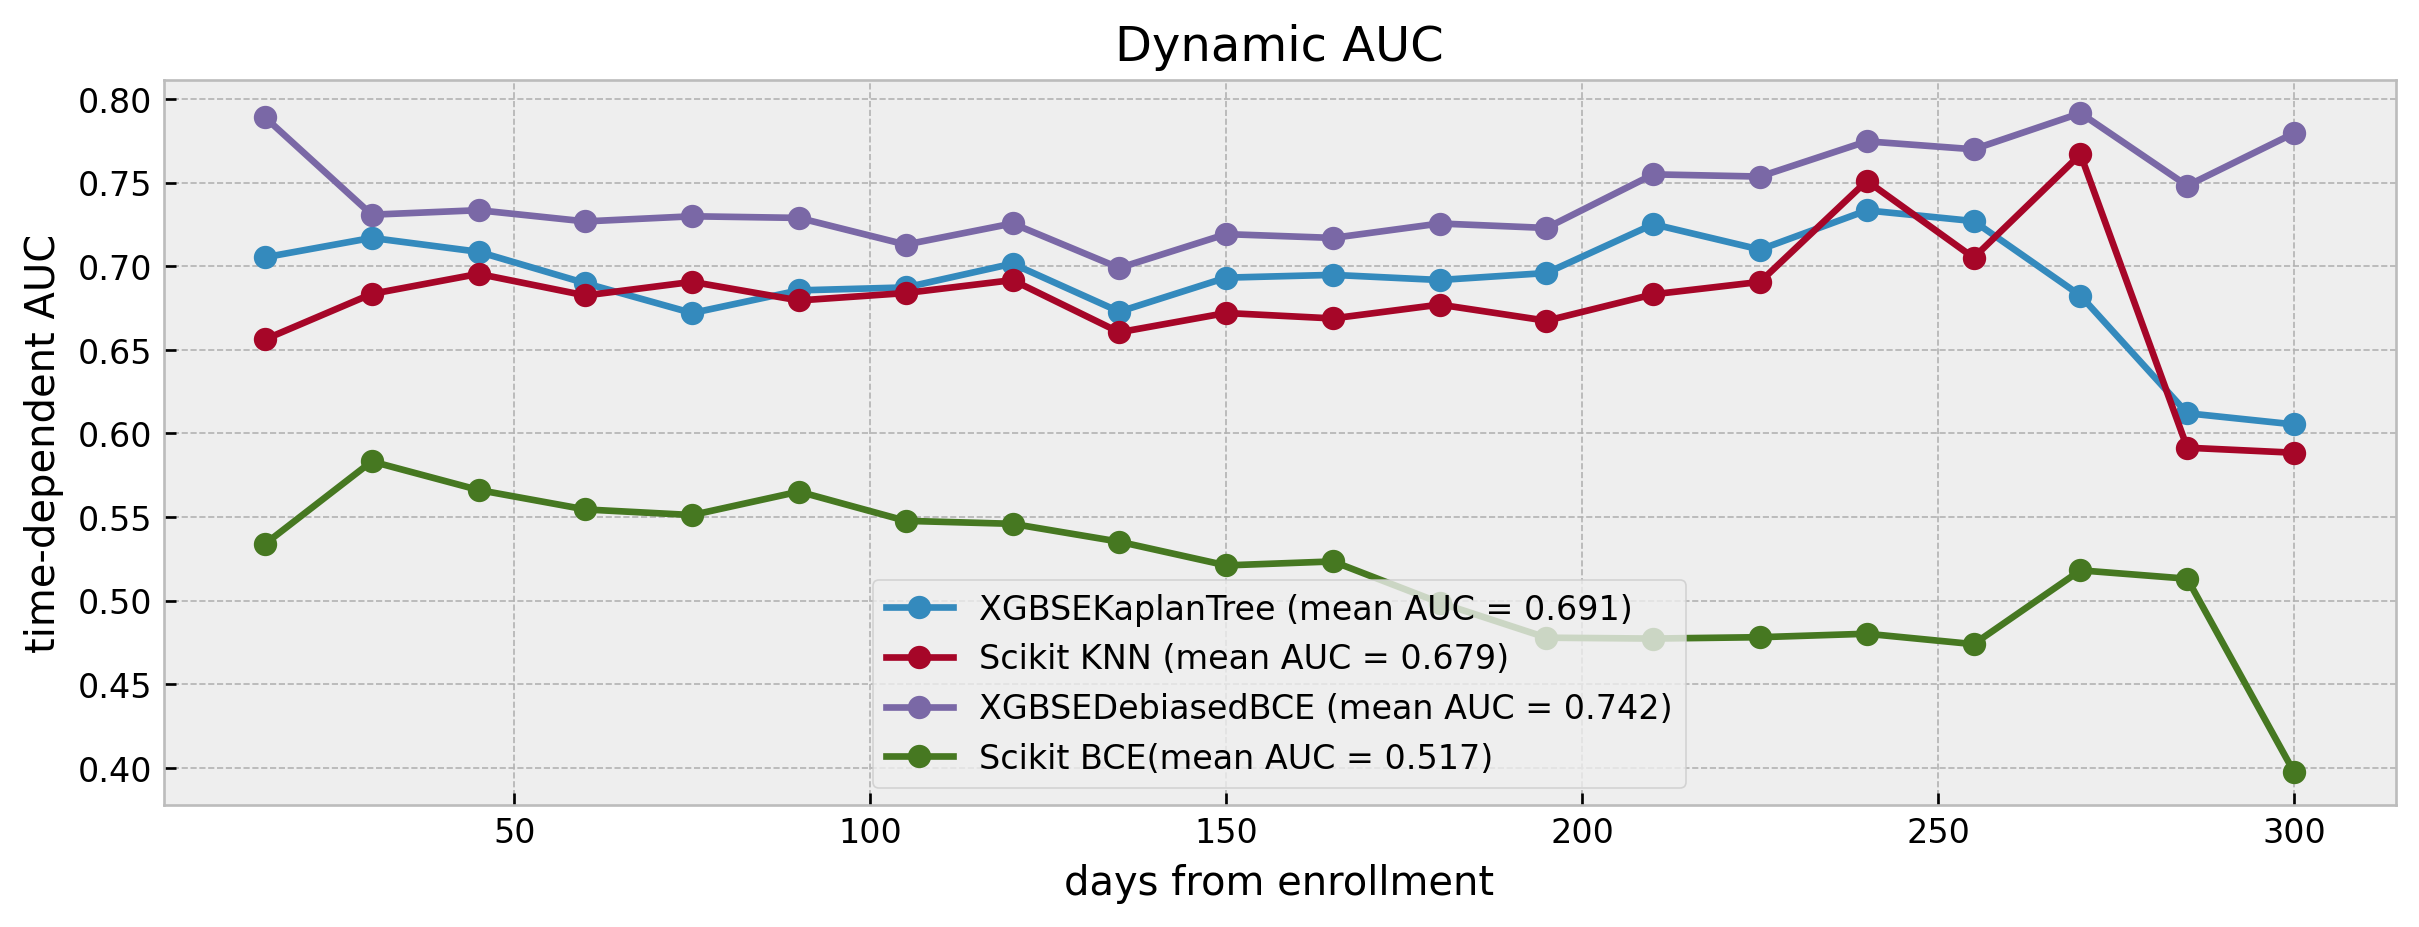

In [35]:
# KNN
auc_xgbse_knn, _ = cumulative_dynamic_auc(y_train, y_test, H_xgbse_knn_df, TIME_BINS)
auc_sk_knn, _ = cumulative_dynamic_auc(y_train, y_test, H_sk_knn_df, TIME_BINS)

# BCE
auc_xgbse_bce, _ = cumulative_dynamic_auc(y_train, y_test, H_xgbse_bce_df, TIME_BINS)
auc_sk_bce, _ = cumulative_dynamic_auc(y_train, y_test, H_sk_bce_df, TIME_BINS)

plot_dynamic_auc(auc_xgbse_knn, auc_sk_knn, auc_xgbse_bce, auc_sk_bce)

When it comes to Dynamic AUC, `XGBSEDebiased` is ahead, Scikit KNN matches `XGBSEKaplanTree`

In [45]:
def plot_dual(s_xgbse_knn_df, s_sk_knn_df, s_xgbse_bce_df, s_sk_bce_df, idx):
    # plotting survival curve
    fig = plt.figure(figsize=(12, 4), dpi=120)
    ax = fig.add_subplot(111)
    ax.plot(s_xgbse_knn_df.columns, s_xgbse_knn_df.iloc[idx], label="XGBSEKaplanTree");
    ax.plot(s_sk_knn_df.columns, s_sk_knn_df.iloc[idx], label="Scikit KNN");
    ax.plot(s_xgbse_bce_df.columns, s_xgbse_bce_df.iloc[idx], label="XGBSEDebiasedBCE");
    ax.plot(s_sk_bce_df.columns, s_sk_bce_df.iloc[idx], label="Scikit BCE");
    plt.tight_layout();
    plt.title(f"Survival probability for sample {idx} | y_test: {y_test[idx]}")
    plt.legend();

We plot survival curves from all models for a chosen sample.

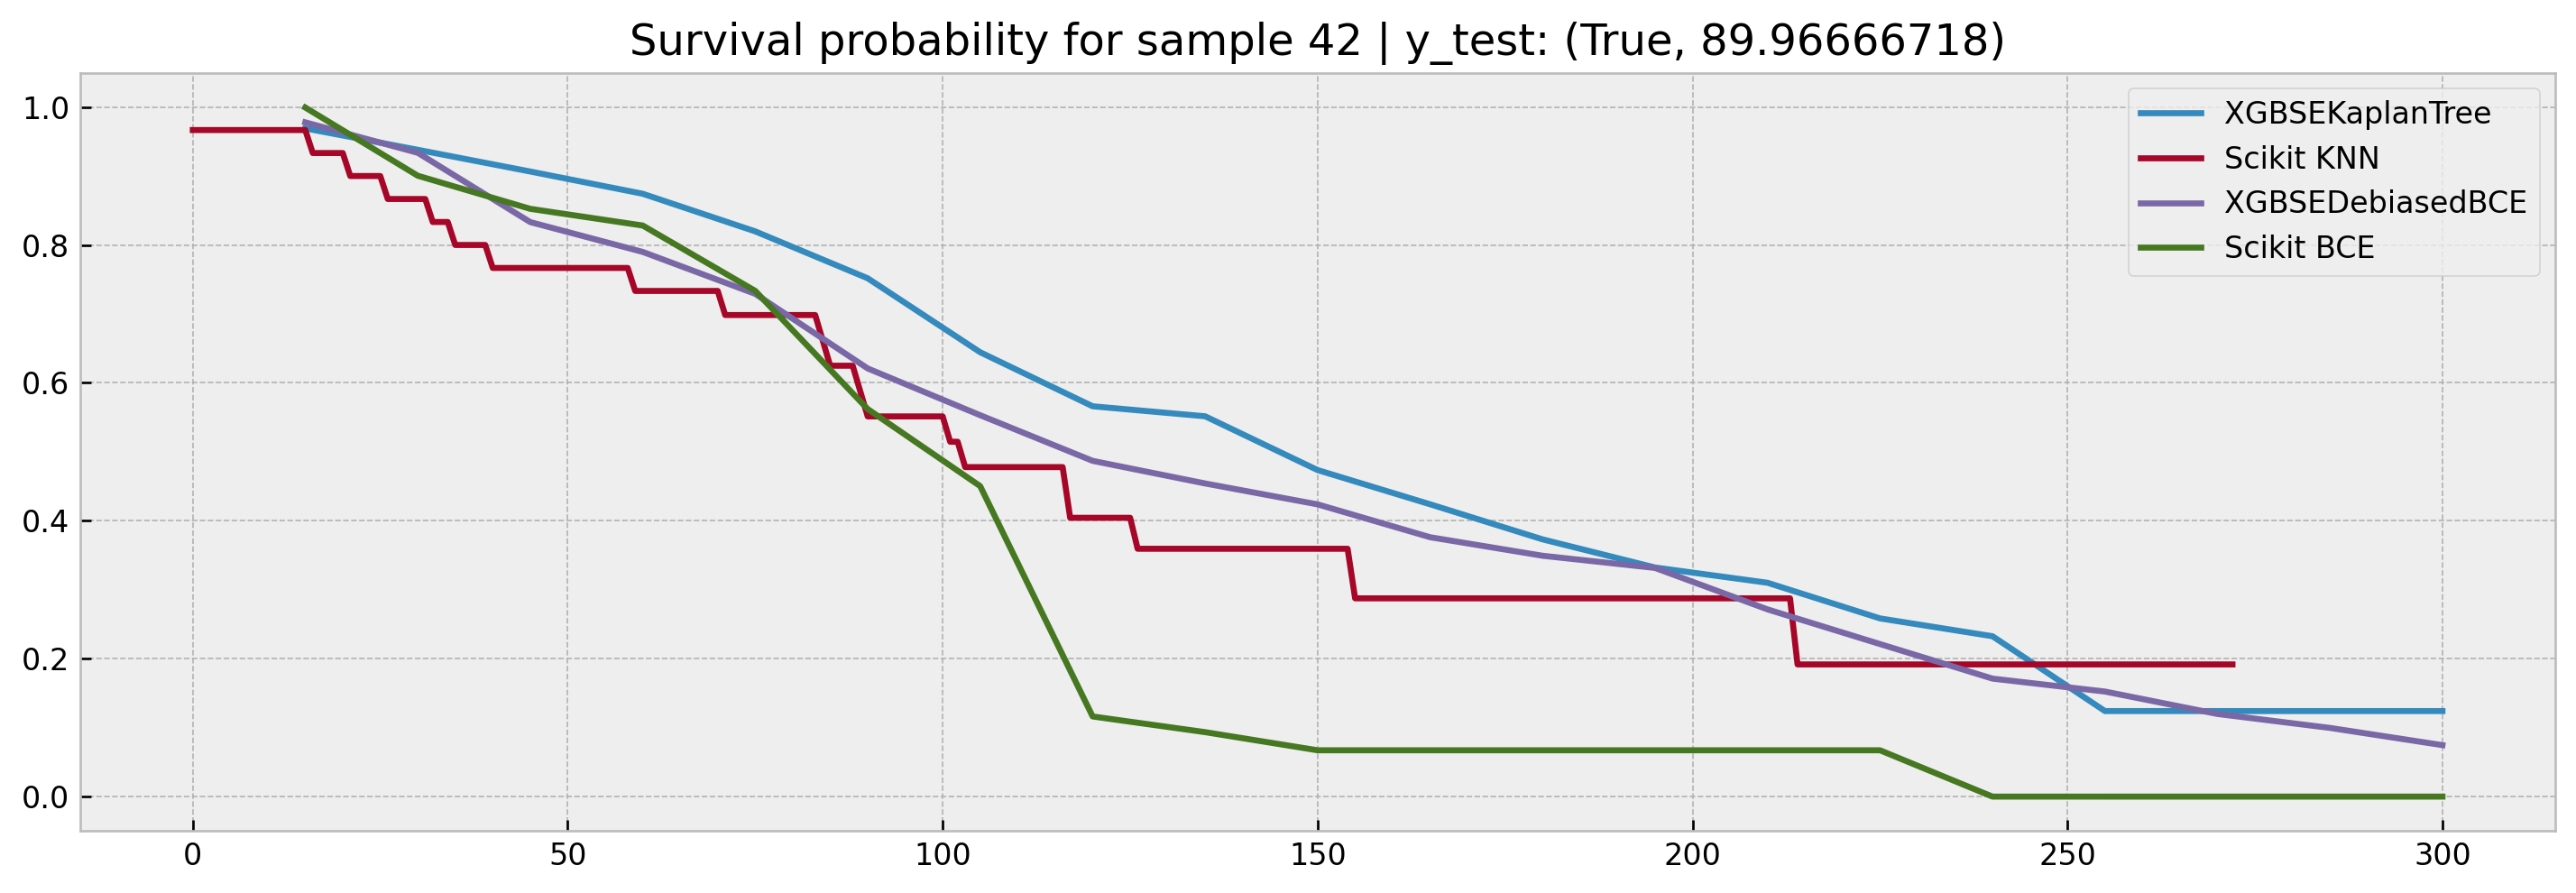

In [53]:
plot_dual(s_xgbse_knn_df, s_sk_knn_df, s_xgbse_bce_df, s_sk_bce_df, idx=42)